In [1]:
import torch
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
tqdm.pandas()

In [2]:
data = pd.read_parquet('data/reviews_cleaned.pq')

In [3]:
data.head()

,user_name,review,date,rating,app_name
index,,,,,
0,"mov ax,1/int 21h",OVERALL If youre tired of companies like faceb...,2021-07-24 13:51:42,4,telegram-messenger
1,girlwithLion,edit: the gift subscription button is not work...,2022-08-23 03:17:01,5,telegram-messenger
2,Mr.. Fisher,"Hey, Ive been using Telegram for over 10+ year...",2021-02-18 15:00:42,3,telegram-messenger
3,Zakir Hosen,I am enjoying telegram as my main chatting app...,2019-09-20 15:54:38,4,telegram-messenger
4,Mr Bcubed,The genuine telegram app deletes text messages...,2020-05-30 05:14:18,5,telegram-messenger


In [4]:
data.date.min()

Timestamp('2017-09-04 22:16:56')

In [5]:
data.date.max()

Timestamp('2022-12-02 01:53:52')

## Ratings

In [6]:
for app in data.app_name.unique():
    print(f'App: {app}')
    print(f'Mean: {round(data[data.app_name == app].rating.mean(), 2)}')
    print(f'Median: {data[data.app_name == app].rating.median()}')
    print('---------------------------------------')

App: telegram-messenger
Mean: 3.69
Median: 4.0
---------------------------------------
App: whatsapp-messenger
Mean: 3.93
Median: 5.0
---------------------------------------
App: facebook-messenger
Mean: 2.55
Median: 2.0
---------------------------------------


<AxesSubplot: xlabel='rating', ylabel='count'>

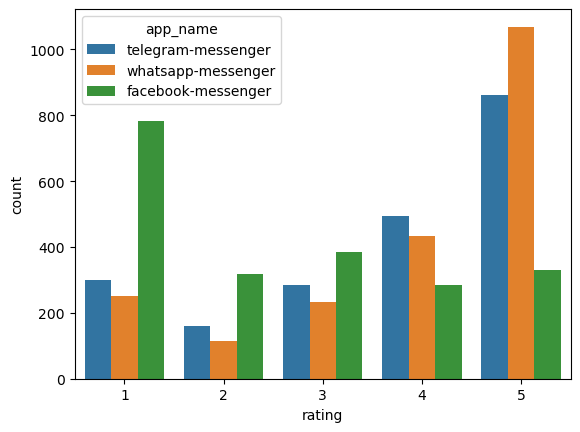

In [7]:
sns.countplot(data=data, x='rating', hue='app_name')

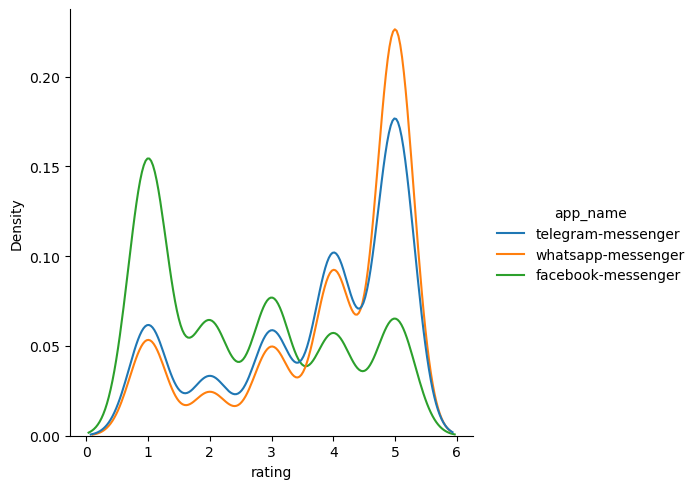

In [8]:
sns.displot(data=data, x='rating', hue='app_name', kind='kde')

In [27]:
def plot_timeline(data, column):
    df = data[['date', 'app_name', column]].copy()
    
    df['date'] = pd.to_datetime(
        df['date'].astype(str).apply(
            lambda x: '-'.join(x.split(' ')[0].split('-')[:2]) + '-01'
        )
    )
    
    grouped = df.groupby(by=['date', 'app_name'], as_index=False).mean()

    plt.figure(figsize=(30, 10))
    sns.lineplot(data=grouped, x='date', y=column, hue='app_name')

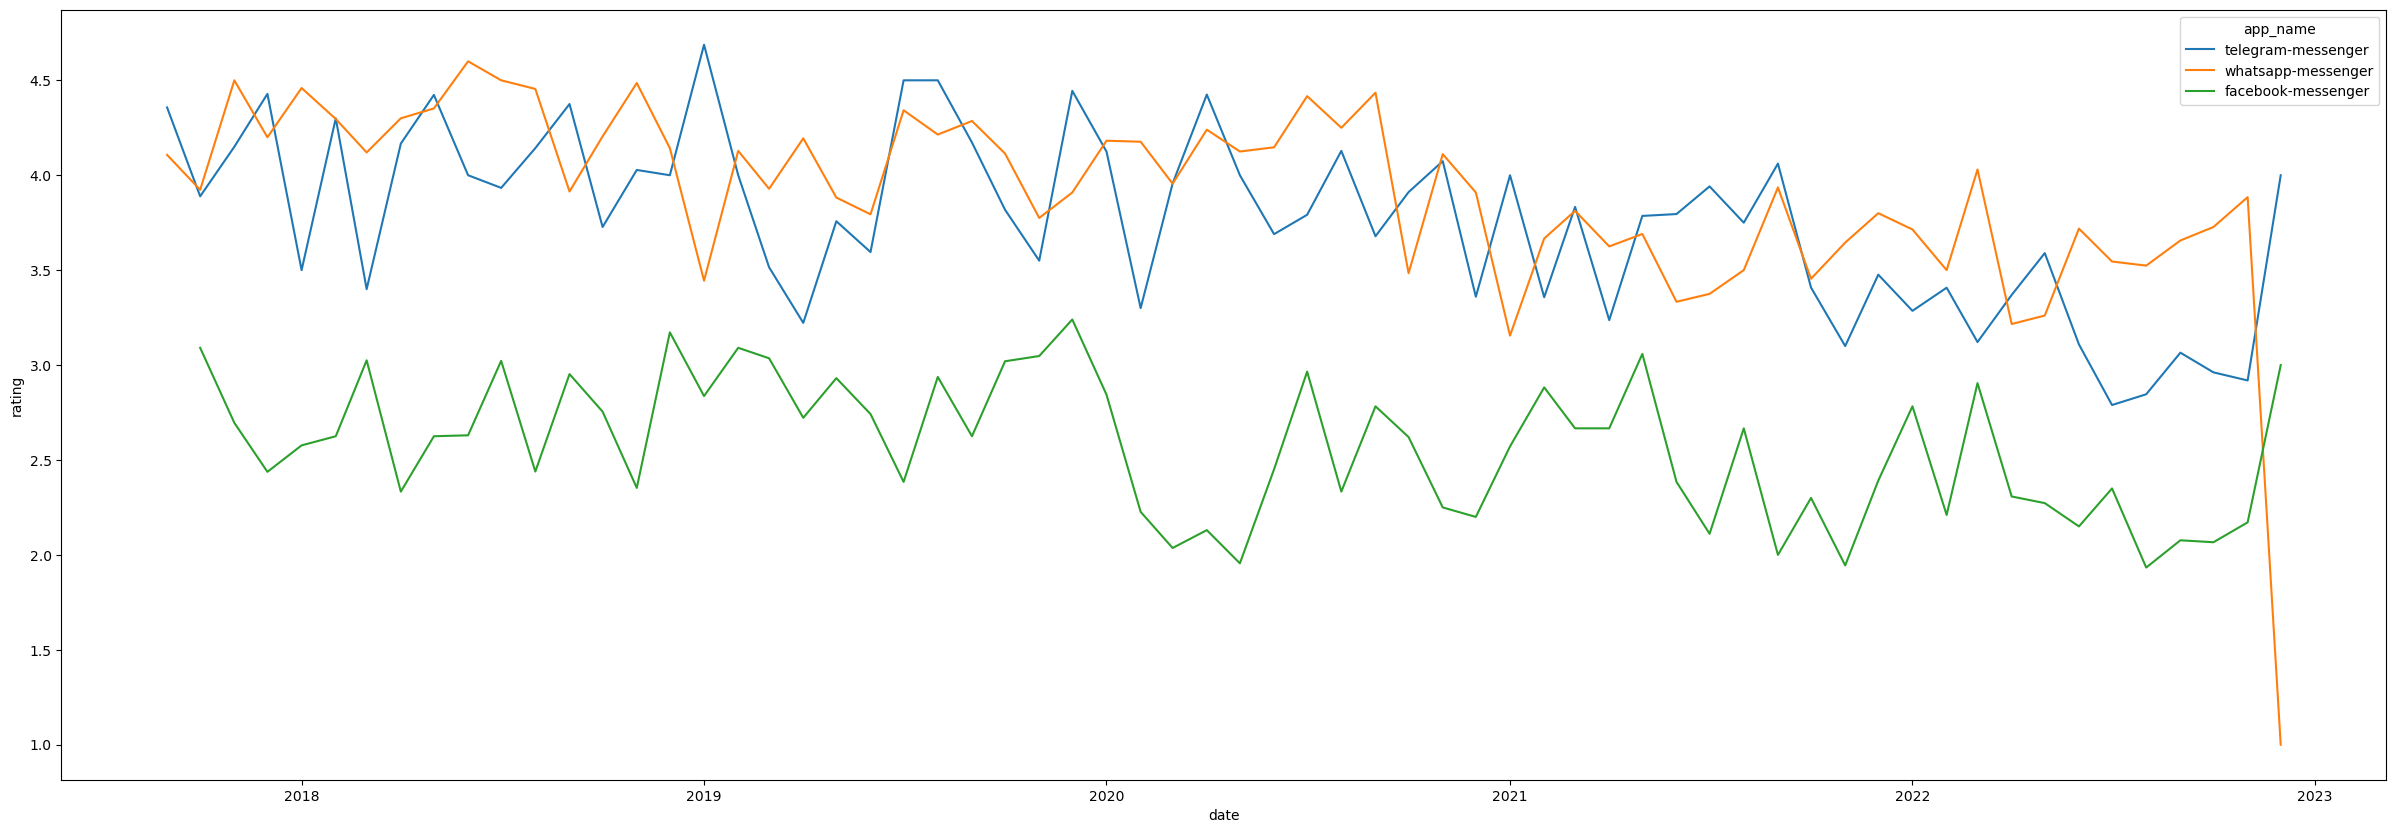

In [10]:
plot_timeline(data, 'rating') # drop in whatsapp may be connected to a worldwide failure in the end of October

## Sentiment

In [11]:
import transformers
from transformers import pipeline

transformers.utils.logging.set_verbosity_error()

In [12]:
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

In [13]:
def classify(text):
    return sentiment_analysis(text)[0]['label']

In [14]:
data['sentiment'] = data.review.progress_apply(classify)

  0%|          | 0/6300 [00:00<?, ?it/s]

In [15]:
data.head()

,user_name,review,date,rating,app_name,sentiment
index,,,,,,
0,"mov ax,1/int 21h",OVERALL If youre tired of companies like faceb...,2021-07-24 13:51:42,4,telegram-messenger,POSITIVE
1,girlwithLion,edit: the gift subscription button is not work...,2022-08-23 03:17:01,5,telegram-messenger,POSITIVE
2,Mr.. Fisher,"Hey, Ive been using Telegram for over 10+ year...",2021-02-18 15:00:42,3,telegram-messenger,NEGATIVE
3,Zakir Hosen,I am enjoying telegram as my main chatting app...,2019-09-20 15:54:38,4,telegram-messenger,NEGATIVE
4,Mr Bcubed,The genuine telegram app deletes text messages...,2020-05-30 05:14:18,5,telegram-messenger,POSITIVE


In [16]:
data['review'].iloc[4508]

"Message to Facebook I'm extremely furious by your bias policy favoring Israel and censoring Palestinian views and those who stand against Israeli well-documented crimes by even Israeli and American human rights organization. B'Tselem and Human Rights Watch among many others call Israel an apartheid state, and instead of Facebook being on the forefront against any racist regime, you take the side of the occupier, the colonial and the oppressor. This is a totally immoral and scandalous practice that you should stop immediately. The current war crimes against the Palestinian civilians particularly in the Gaza Strip should put any party that keeps silent to total shame and disgrace. . . . . #MarkZuckerberg #savepalestine #savealsheikhjarrah #___ #PalestineWillBeFree #PalestinianLivesMatter #savesheikhjarrah #Palestine #73yearsOfNakba #TimeForNakbaToEnd"

In [17]:
data['sentiment'].iloc[4508]

'NEGATIVE'

In [19]:
data['review'].iloc[3]

'I am enjoying telegram as my main chatting app as its secure faster & fun to use! But unfortunately it has only voice calling feature which makes me to use another apps for that feature only! I cordially expect that developer will add that asap! Its passcode locking feature in order to provide best security to its user, but apps lock doesnt work immediately! Which should be must! The minimum time is 1 minutes! It should be locked within a fraction of second as some other apps do! As long as we have face unlocking feature so it will not bother us! Lastly, I have facing an unexpected issue sometimes! Im not sure where I tap but when it happens telegram stop functioning & start glitching non stop glitching! It needs the apps to launch again! So please make the apps more lovely by adding video calling features and make the passcode lock more quicker & fix the bug! Thanks for reading with patience!'

In [20]:
data['sentiment'].iloc[3]

'NEGATIVE'

In [21]:
data['review'].iloc[3149]

'I have been enjoying WhatsApp for a long time now and Im amazed by all of the improvements and updates they have brought to WhatsApp. Theres one missing feature that I have always been expecting ever since I started using WhatsApp and thats Dark Mode, dark mode would make a huge positive difference on not just the app but our health as well. I would really appreciate if you guys can please take the time to read my review and provide me with a response in regards to this feature that not just me but the whole WhatsApp community has been waiting for for so long. Thank you WhatsApp team!!!'

In [22]:
data['sentiment'].iloc[3149]

'POSITIVE'

<AxesSubplot: xlabel='sentiment', ylabel='count'>

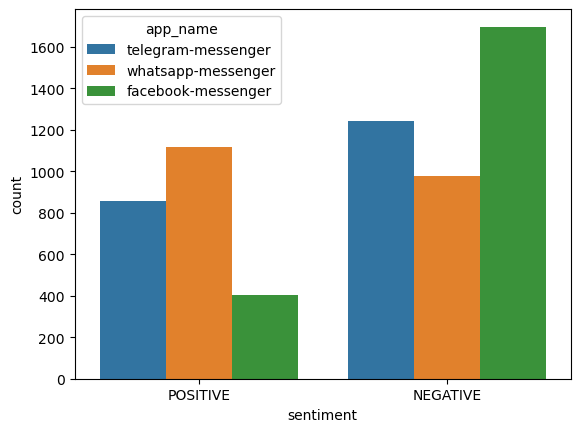

In [23]:
sns.countplot(data=data, x='sentiment', hue='app_name')

In [24]:
data.to_parquet('data/reviews_with_sentiment.pq', compression='GZIP')

In [25]:
data['sentiment'] = data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})

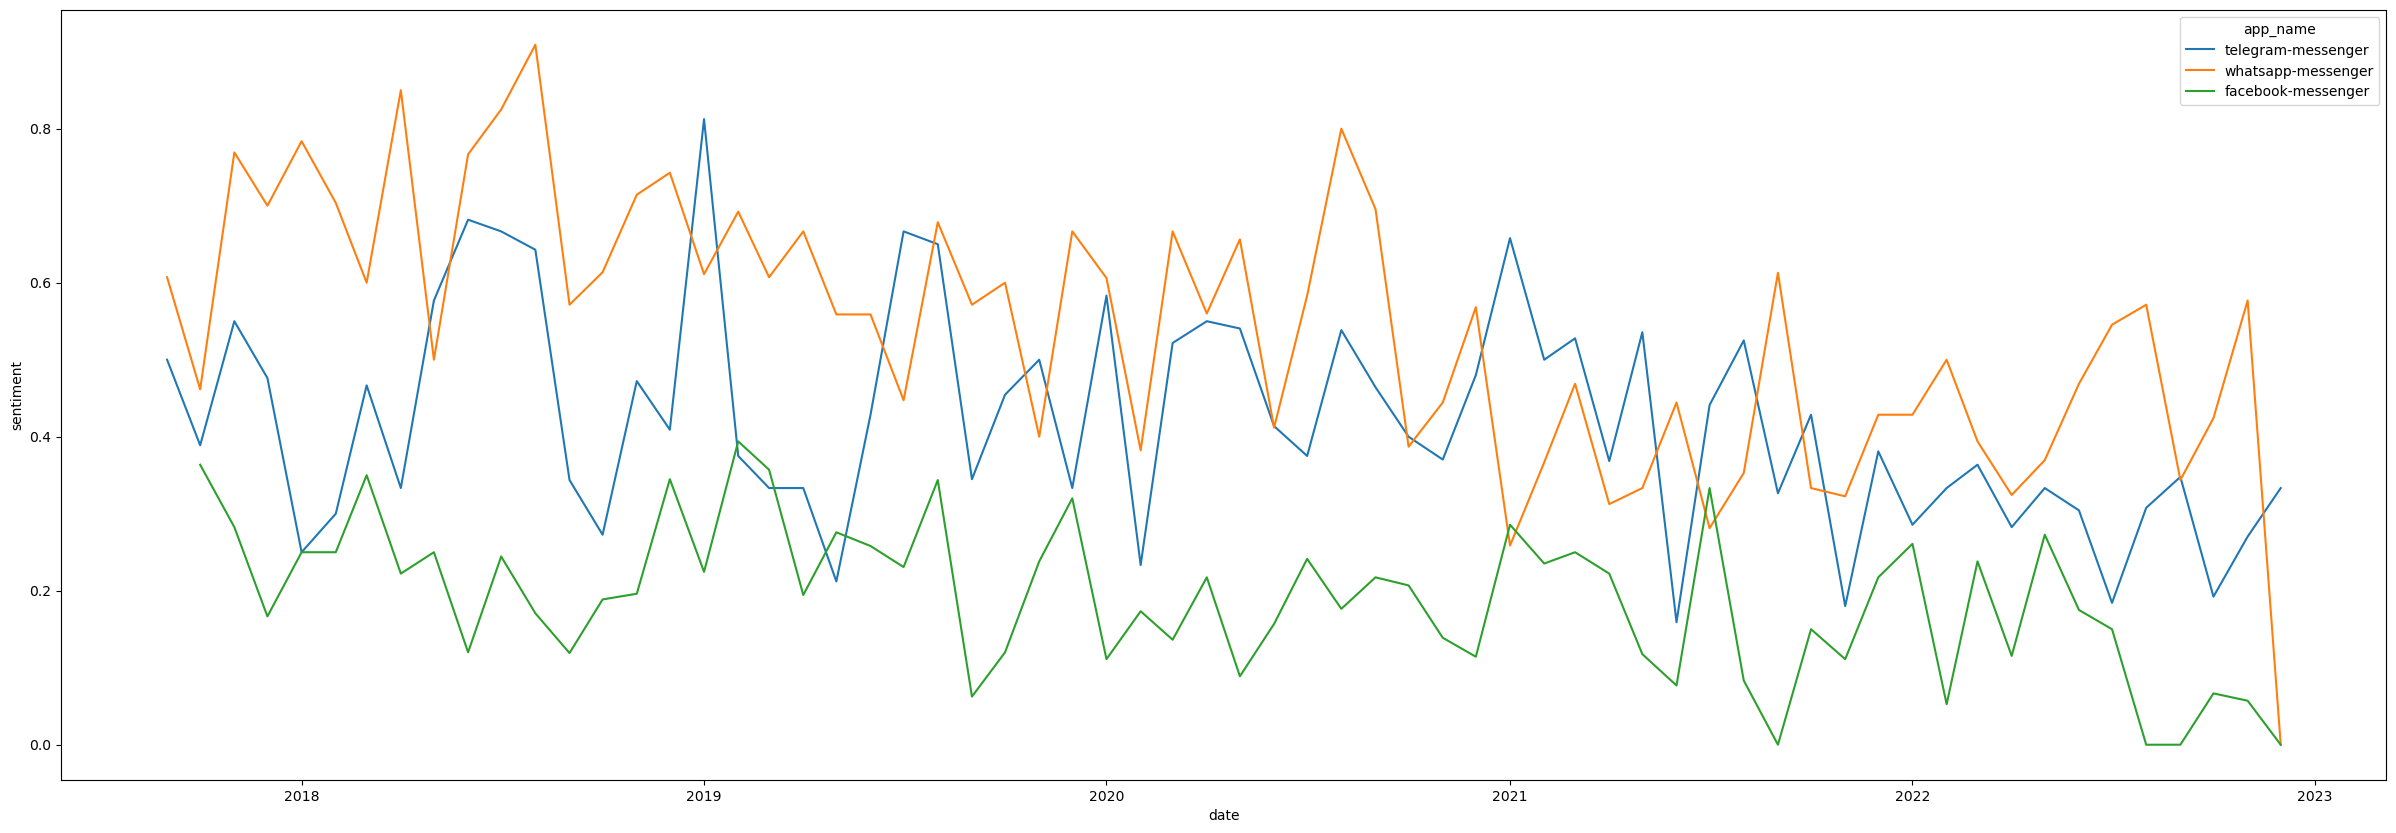

In [28]:
plot_timeline(data, 'sentiment')